# CNN-LSTM-MLP Multimodal Composer Classification

This notebook contains the CNN-LSTM-MLP fusion model architecture and training pipeline for composer classification.

## Model Architecture
- **CNN Blocks**: Extracts spatial features from piano rolls
- **LSTM Layer**: Captures temporal dependencies in CNN features
- **MLP Stream**: Processes hand-crafted musical features
- **Fusion Layer**: Combines LSTM and MLP outputs for final classification

In [4]:
%pip install pretty_midi

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import pickle

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

🔧 Utils and dependencies imported
🚀 Using CUDA GPU: NVIDIA A100-SXM4-40GB


In [23]:
import importlib
import utils

importlib.reload(utils)

from utils import *

print("🔧 Utils and dependencies imported")
device = get_device()


🔧 Utils and dependencies imported
🚀 Using Apple Silicon GPU (MPS)


In [8]:
# download dataset
paths = download_dataset()

Dataset downloaded and extracted to data/kaggle/midiclassics


In [20]:
# Shallow CNN + LSTM (2 CNN layers, 4 LSTM layers, Attention)
class ShallowCNNLSTMClassifier(nn.Module):
    """
    Shallow CNN + LSTM model for piano roll classification.
    - 2 CNN layers for local feature extraction
    - 4-layer LSTM for temporal modeling
    - Attention mechanism after LSTM
    - Optional MLP for hand-crafted features (optional, can be omitted)
    """
    def __init__(self, num_classes=4, num_features=None, lstm_hidden=128, lstm_layers=4):
        super(ShallowCNNLSTMClassifier, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers

        self.lstm = nn.LSTM(
            input_size=64*32,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False
        )

        # Attention mechanism (additive attention)
        self.attn = nn.Linear(lstm_hidden, 1)

        if num_features is not None:
            self.mlp_stream = nn.Sequential(
                nn.Linear(num_features, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.1)
            )
            fusion_input_dim = lstm_hidden + 32
        else:
            self.mlp_stream = None
            fusion_input_dim = lstm_hidden

        # fusion Layer (combine LSTM and MLP outputs)
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, piano_roll, features=None):
        # CNN processes piano rolls
        x = self.cnn(piano_roll)  # (batch, 64, 32, T//4)
        batch, channels, height, width = x.shape  # (B, 64, 32, T//4)
        # Prepare for LSTM: (batch, width, channels*height)
        x = x.permute(0, 3, 1, 2).reshape(batch, width, channels * height)  # (B, seq_len, feature_dim)

        lstm_out, _ = self.lstm(x)  # (B, seq_len, lstm_hidden)

        # Attention: compute attention weights and weighted sum
        attn_weights = torch.softmax(self.attn(lstm_out).squeeze(-1), dim=1)  # (B, seq_len)
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # (B, lstm_hidden)

        # Optional MLP stream for musical features
        if self.mlp_stream is not None and features is not None:
            mlp_features = self.mlp_stream(features)
            combined = torch.cat([attn_applied, mlp_features], dim=1)
        else:
            combined = attn_applied

        output = self.fusion(combined)
        return output

In [ ]:
def train_cnn_lstm_mlp_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=40, device='cpu'):
    """
    Train the CNN-LSTM-MLP multimodal model

    Args:
        model: CNN-LSTM-MLP model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        epochs (int): Number of epochs to train
        device (str): Device to train on

    Returns:
        tuple: (train_losses, val_accuracies)
    """
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0

        for piano_rolls, features, labels in train_loader:
            piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(piano_rolls, features)
            loss = criterion(outputs, labels)

            # Gradient clipping for LSTM stability
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for piano_rolls, features, labels in val_loader:
                piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)
                outputs = model(piano_rolls, features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        avg_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(val_accuracy)

        print(f'[CNN-LSTM-MLP] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        scheduler.step()

    return train_losses, val_accuracies

In [24]:
TARGET_COMPOSERS = ["Bach", "Beethoven", "Mozart", "Chopin"]

data, labels, features, song_ids = load_segmented_dataset_no_overlap(paths["extract_path"], TARGET_COMPOSERS)


LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...
Segment duration: 20.0s with NO OVERLAP
Balance classes: True

--- Processing Bach ---
  Processed 10 files, created 155 segments...
  Processed 10 files, created 155 segments...
  Processed 20 files, created 289 segments...
  Processed 20 files, created 289 segments...
  Processed 30 files, created 485 segments...
  Processed 30 files, created 485 segments...
  Processed 40 files, created 670 segments...
  Processed 40 files, created 670 segments...
  Processed 50 files, created 827 segments...
  Processed 50 files, created 827 segments...
  Processed 60 files, created 1037 segments...
  Processed 60 files, created 1037 segments...
  Processed 70 files, created 1206 segments...
  Processed 70 files, created 1206 segments...
  Processed 80 files, created 1406 segments...
  Processed 80 files, created 1406 segments...
  Processed 90 files, created 1502 segments...
  Processed 90 files, created 1502 segments...
  Processed 100 files, c

In [25]:
song_ids[0:5]

['data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__0',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__1',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__2',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__3',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__4']

In [26]:
comprehensive_features = load_comprehensive_features(data)


Loading comprehensive_features from cache: local_cache/comprehensive_musical_features.pkl


In [27]:
train_loader, val_loader = create_songwise_data_loaders(
    data,
    labels,
    comprehensive_features,
    song_ids,
    batch_size=32,
    train_split=0.8,
    dataset_class=MultimodalDataset
)

Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
Multimodal Dataset Created:
Piano rolls: torch.Size([7305, 128, 2000])
Features: torch.Size([7305, 30])
Labels: torch.Size([7305])
Total samples: 7305
Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
Multimodal Dataset Created:
Piano rolls: torch.Size([1827, 128, 2000])
Features: torch.Size([1827, 30])
Labels: torch.Size([1827])
Total samples: 1827
Songwise Data Loaders Created:
• Training samples: 7305
• Validation samples: 1827
• Batch size: 32


In [28]:
# 5. Inspect a batch (for debugging)
piano_rolls, features_batch, labels_batch = next(iter(train_loader))
print('Piano roll batch shape:', piano_rolls.shape)  # (batch, 1, 128, T)
print('Features batch shape:', features_batch.shape)  # (batch, num_features)
print('Labels batch shape:', labels_batch.shape)  # (batch,)

# Now ready to use train_loader with your model!

Piano roll batch shape: torch.Size([32, 1, 128, 2000])
Features batch shape: torch.Size([32, 30])
Labels batch shape: torch.Size([32])


In [ ]:
# training

num_classes = len(TARGET_COMPOSERS)
num_features = len(comprehensive_features[0])
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

train_losses, val_accuracies = train_cnn_lstm_mlp_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, device=device
)

Detected num_features: 30
[CNN-LSTM-MLP] Epoch [1/35], Loss: 0.9320, Val Acc: 77.39%
[CNN-LSTM-MLP] Epoch [2/35], Loss: 0.5990, Val Acc: 77.72%
[CNN-LSTM-MLP] Epoch [3/35], Loss: 0.4907, Val Acc: 83.14%
[CNN-LSTM-MLP] Epoch [4/35], Loss: 0.4168, Val Acc: 84.35%
[CNN-LSTM-MLP] Epoch [5/35], Loss: 0.3675, Val Acc: 87.03%
[CNN-LSTM-MLP] Epoch [6/35], Loss: 0.3396, Val Acc: 87.96%
[CNN-LSTM-MLP] Epoch [7/35], Loss: 0.3052, Val Acc: 88.40%
[CNN-LSTM-MLP] Epoch [8/35], Loss: 0.2774, Val Acc: 88.94%
[CNN-LSTM-MLP] Epoch [9/35], Loss: 0.2379, Val Acc: 88.83%
[CNN-LSTM-MLP] Epoch [10/35], Loss: 0.2414, Val Acc: 83.69%
[CNN-LSTM-MLP] Epoch [11/35], Loss: 0.1873, Val Acc: 90.64%
[CNN-LSTM-MLP] Epoch [12/35], Loss: 0.1634, Val Acc: 91.24%
[CNN-LSTM-MLP] Epoch [13/35], Loss: 0.1542, Val Acc: 91.84%
[CNN-LSTM-MLP] Epoch [14/35], Loss: 0.1433, Val Acc: 92.34%
[CNN-LSTM-MLP] Epoch [15/35], Loss: 0.1284, Val Acc: 92.88%
[CNN-LSTM-MLP] Epoch [16/35], Loss: 0.1130, Val Acc: 92.28%
[CNN-LSTM-MLP] Epoch [1

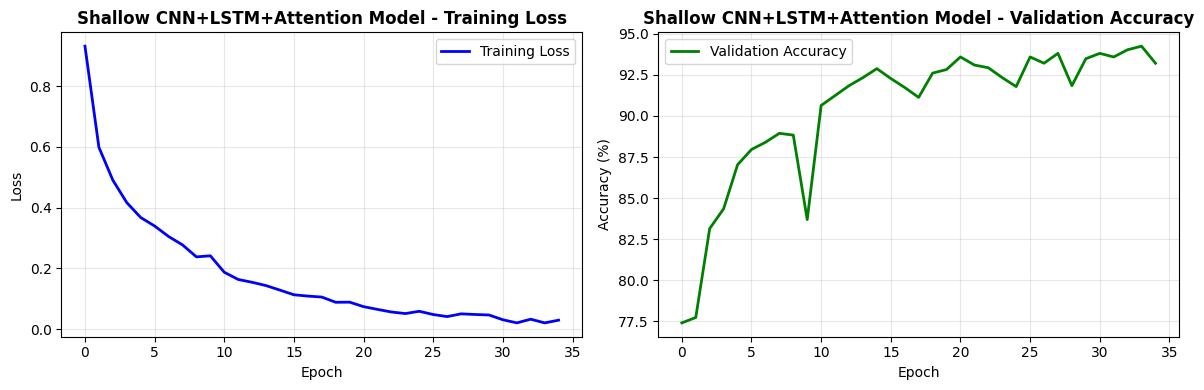

In [17]:

# 4. Plot training curves (if you have a plotting function)
plot_training_curves(train_losses, val_accuracies, "Shallow CNN+LSTM+Attention Model")

In [ ]:
model_save_path = "saved_models/shallow_cnn_lstm_attention_model.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to saved_models/shallow_cnn_lstm_attention_model.pth


In [ ]:
# Load the saved model state
model_save_path = "saved_models/shallow_cnn_lstm_attention_model.pth"
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)
model.load_state_dict(torch.load(model_save_path))

print(f"Model loaded from {model_save_path}")

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9702    0.9723    0.9712       469
   Beethoven     0.9453    0.8315    0.8847       457
      Mozart     0.8962    0.9574    0.9258       469
      Chopin     0.9207    0.9676    0.9436       432

    accuracy                         0.9321      1827
   macro avg     0.9331    0.9322    0.9313      1827
weighted avg     0.9333    0.9321    0.9314      1827



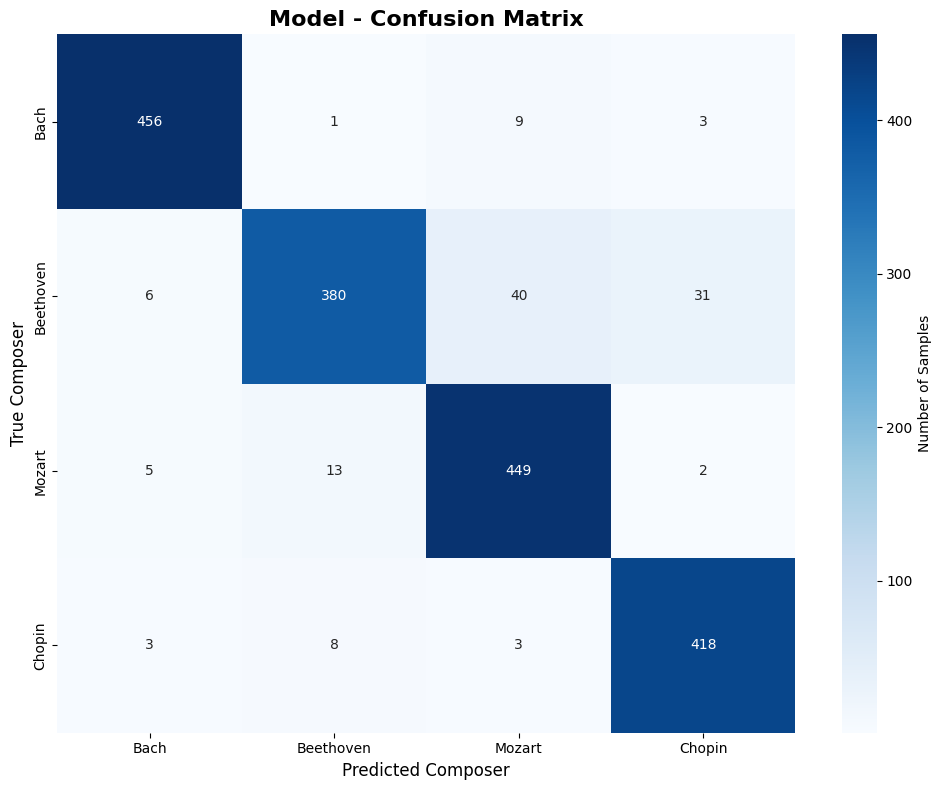


🎯 PER-CLASS ACCURACY:
Bach        : 0.9723 (97.23%)
Beethoven   : 0.8315 (83.15%)
Mozart      : 0.9574 (95.74%)
Chopin      : 0.9676 (96.76%)

🏆 OVERALL ACCURACY: 0.9321 (93.21%)

❌ MOST CONFUSED PAIRS:
Beethoven → Mozart: 40 samples
Beethoven → Chopin: 31 samples
Mozart → Beethoven: 13 samples
Bach → Mozart: 9 samples
Chopin → Beethoven: 8 samples


In [21]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

[CNN-LSTM-MLP] Epoch [1/15], Loss: 0.0091, Val Acc: 93.92%
[CNN-LSTM-MLP] Epoch [2/15], Loss: 0.0070, Val Acc: 93.65%
[CNN-LSTM-MLP] Epoch [3/15], Loss: 0.0080, Val Acc: 94.14%
[CNN-LSTM-MLP] Epoch [4/15], Loss: 0.0116, Val Acc: 93.49%
[CNN-LSTM-MLP] Epoch [5/15], Loss: 0.0057, Val Acc: 93.60%
[CNN-LSTM-MLP] Epoch [6/15], Loss: 0.0049, Val Acc: 93.87%
[CNN-LSTM-MLP] Epoch [7/15], Loss: 0.0029, Val Acc: 93.65%
[CNN-LSTM-MLP] Epoch [8/15], Loss: 0.0047, Val Acc: 93.81%
[CNN-LSTM-MLP] Epoch [9/15], Loss: 0.0061, Val Acc: 93.87%
[CNN-LSTM-MLP] Epoch [10/15], Loss: 0.0058, Val Acc: 94.09%
[CNN-LSTM-MLP] Epoch [11/15], Loss: 0.0061, Val Acc: 94.09%
[CNN-LSTM-MLP] Epoch [12/15], Loss: 0.0040, Val Acc: 94.20%
[CNN-LSTM-MLP] Epoch [13/15], Loss: 0.0042, Val Acc: 94.25%
[CNN-LSTM-MLP] Epoch [14/15], Loss: 0.0048, Val Acc: 94.03%
[CNN-LSTM-MLP] Epoch [15/15], Loss: 0.0040, Val Acc: 94.09%


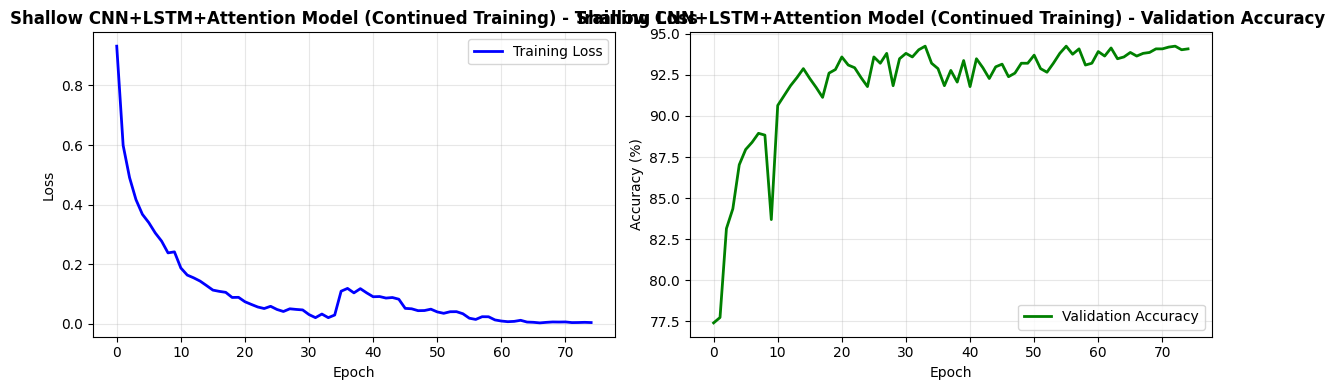

In [23]:
# Continue training the model for 10 more epochs

# Load the saved model state
model_save_path = "saved_models/shallow_cnn_lstm_attention_model.pth"
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)
model.load_state_dict(torch.load(model_save_path))

class_weights = torch.tensor([1.0, 1.3, 1.0, 1.0]).to(device)

# Set up loss, optimizer, scheduler (using the same ones from previous training)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Continue training for 10 more epochs
train_losses_cont, val_accuracies_cont = train_cnn_lstm_mlp_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, device=device
)

# Optionally, combine the training history for plotting
train_losses.extend(train_losses_cont)
val_accuracies.extend(val_accuracies_cont)

# Plot the updated training curves (if you have a plotting function)
plot_training_curves(train_losses, val_accuracies, "Shallow CNN+LSTM+Attention Model (Continued Training)")

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9665    0.9829    0.9746       469
   Beethoven     0.9254    0.8687    0.8962       457
      Mozart     0.9443    0.9403    0.9423       469
      Chopin     0.9251    0.9722    0.9481       432

    accuracy                         0.9409      1827
   macro avg     0.9403    0.9410    0.9403      1827
weighted avg     0.9407    0.9409    0.9404      1827



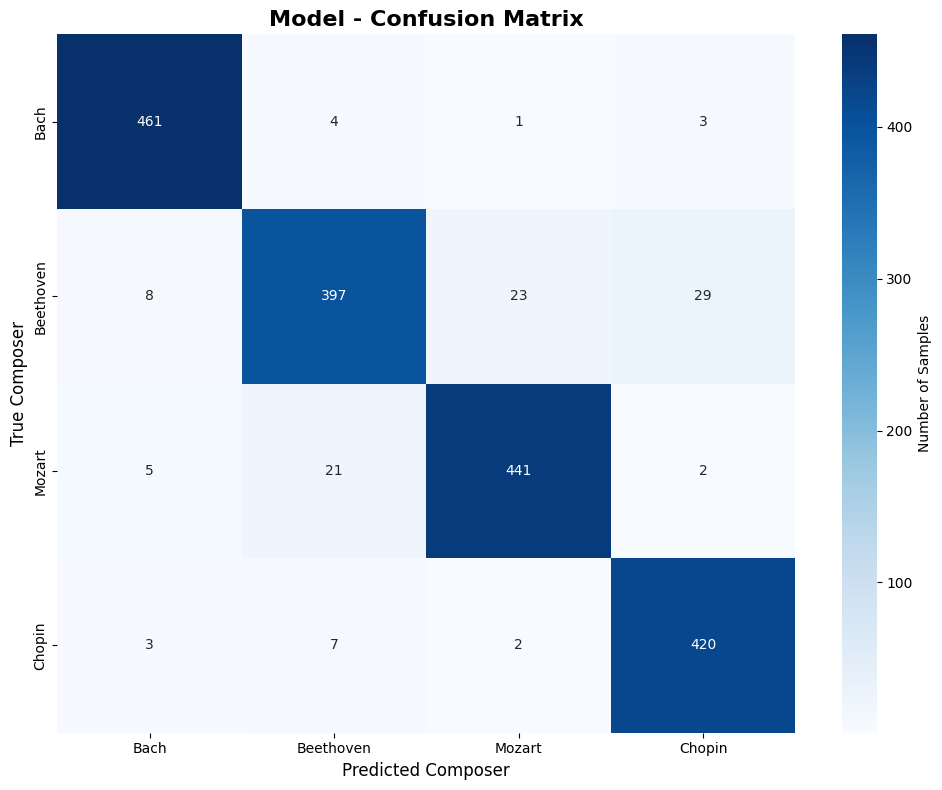


🎯 PER-CLASS ACCURACY:
Bach        : 0.9829 (98.29%)
Beethoven   : 0.8687 (86.87%)
Mozart      : 0.9403 (94.03%)
Chopin      : 0.9722 (97.22%)

🏆 OVERALL ACCURACY: 0.9409 (94.09%)

❌ MOST CONFUSED PAIRS:
Beethoven → Chopin: 29 samples
Beethoven → Mozart: 23 samples
Mozart → Beethoven: 21 samples
Beethoven → Bach: 8 samples
Chopin → Beethoven: 7 samples


In [24]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

In [26]:
torch.save(model.state_dict(), "saved_models/shallow_cnn_lstm_attention_model_2.pth")
print(f"Model saved to {model_save_path}")

Model saved to saved_models/shallow_cnn_lstm_attention_model.pth
